In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [2]:
# nltk 다운로드 필요
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# 데이터 로드
file_path = './wine_review.csv'
df = pd.read_csv(file_path)

# 데이터 구조 확인
# print(df.head())
# print(df.info())

# 결측값 처리: 리뷰 텍스트와 레이팅이 없는 행 제거
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# 불필요한 열 제거
columns_to_drop = ['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 
                   'descriptions', 'dimension', 'ean', 'flavors', 'keys', 
                   'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 
                   'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 
                   'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 
                   'reviews.sourceURLs', 'reviews.userCity', 
                   'reviews.userProvince', 'reviews.username', 'sizes', 
                   'sourceURLs', 'upc', 'weight']
df = df.drop(columns=columns_to_drop)

# reviews.text와 reviews.title을 합쳐서 reviews 열 생성
df['reviews'] = df['reviews.text'].fillna('') + ' ' + df['reviews.title'].fillna('')

# 기존의 reviews.text와 reviews.title 열 삭제
df.drop(columns=['reviews.text', 'reviews.title'], inplace=True)

# 데이터 구조 확인
# print(df.head())
# print(df.info())

# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # 구두점 제거
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 숫자 제거
    text = re.sub(r'\d+', '', text)
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    # 어간 추출 (또는 표제어 추출 사용 가능)
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# 리뷰 텍스트 전처리 적용
df['cleaned_reviews'] = df['reviews'].apply(preprocess_text)

# reviews.rating이 3.0인 행만 남기고 제거
df = df[df['reviews.rating'] != 3.0]

# 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여, 부여된 레이블은 새로 생성한 label이라는 열에 저장
df['label'] = np.where(df['reviews.rating'] > 3, 1, 0)

# 최종 데이터 생성
df.to_csv(r"./wine_review_filtered.csv", index = False)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

# 전처리된 데이터 불러오기
df = pd.read_csv('./wine_review_filtered.csv')

# 특성과 레이블 분리하기
X = df['cleaned_reviews']
y = df['label']

# 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화를 사용하여 텍스트 데이터 변환하기
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# SVM 모델 초기화 및 하이퍼파라미터 그리드 정의
svm_classifier = SVC(probability=True)
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# GridSearchCV 초기화 및 하이퍼파라미터 튜닝
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# 최적의 하이퍼파라미터와 최적의 모델
print(f'최적의 하이퍼파라미터: {grid_search.best_params_}')
print(f'최적의 교차 검증 정확도: {grid_search.best_score_:.2f}')

# 최적의 모델로 테스트 데이터 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vectorized)
y_pred_proba = best_model.predict_proba(X_test_vectorized)[:,1]

# 모델 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'정확도: {accuracy:.2f}')
print(f'정밀도: {precision:.2f}')
print(f'재현율: {recall:.2f}')
print(f'F1 점수: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(classification_report(y_test, y_pred))



최적의 하이퍼파라미터: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
최적의 교차 검증 정확도: 0.96
정확도: 0.96
정밀도: 0.97
재현율: 0.99
F1 점수: 0.98
ROC-AUC: 0.91
              precision    recall  f1-score   support

           0       0.64      0.30      0.41        23
           1       0.97      0.99      0.98       453

    accuracy                           0.96       476
   macro avg       0.80      0.65      0.69       476
weighted avg       0.95      0.96      0.95       476



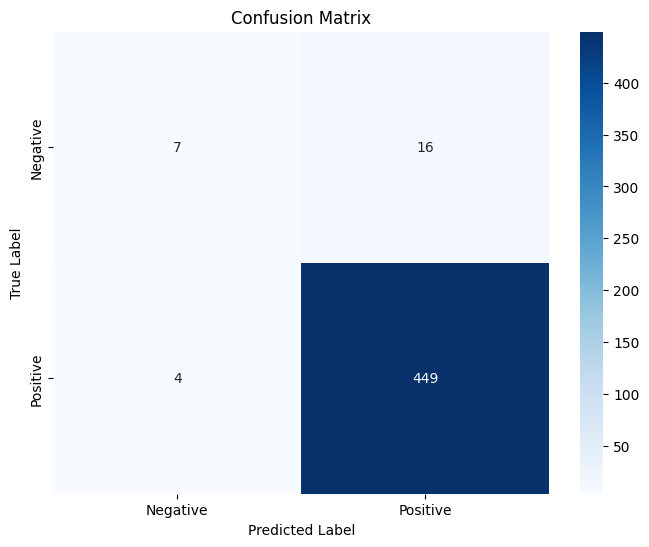

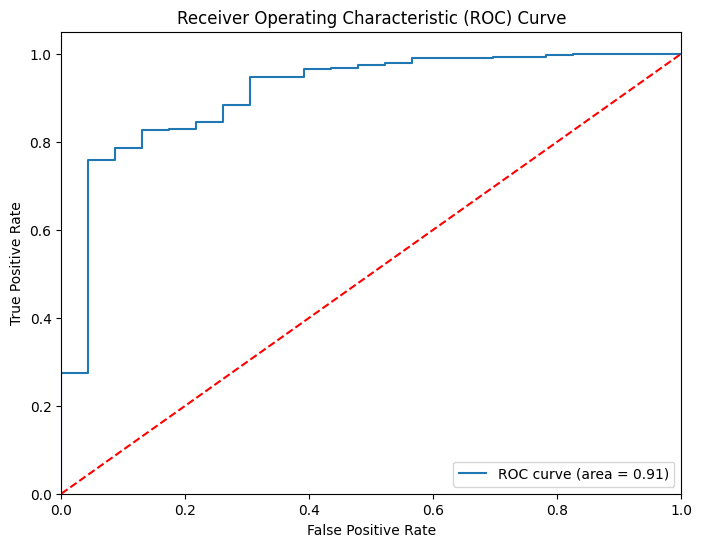

In [9]:
# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC 곡선 생성 및 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()